In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import expit

from sklearn.preprocessing import PolynomialFeatures

# DGP

(array([518., 263., 103.,  62.,  33.,  12.,   7.,   0.,   1.,   1.]),
 array([2.11384718e+00, 7.83647339e+02, 1.56518083e+03, 2.34671432e+03,
        3.12824782e+03, 3.90978131e+03, 4.69131480e+03, 5.47284829e+03,
        6.25438178e+03, 7.03591528e+03, 7.81744877e+03]),
 <BarContainer object of 10 artists>)

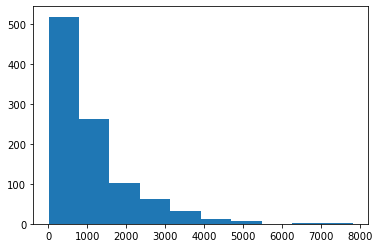

In [2]:
plt.hist(np.random.exponential(1000,1000))

In [3]:
def sample_sparse_coefs(nx, p=0.8):
            return np.random.uniform(-5, 5, nx)*np.random.binomial(1, p, nx)
    
    
def sample_from(dist, mu, var, n):
    if dist == "gamma":
        return np.random.gamma(mu**2/var, np.abs(var/mu), n)
    
    if dist == "normal":
        return np.random.normal(mu, np.sqrt(var), n)
    
    if dist == "uniform":
        a = mu-np.sqrt(3 * var)
        return np.random.uniform(a, 2*mu - a, n)
    

def risk_fn(risk_latent, bias=0, temp=0.1):
    return expit(risk_latent*temp + bias)


def sample_default(risk):
    return np.random.binomial(1, risk)


def sample_loan_amt(base_latent_risk):
    mu = ((base_latent_risk-base_latent_risk.mean())/base_latent_risk.std())
    shape = 50*((mu+5).clip(0, np.inf)**2)/np.var(base_latent_risk)
    return np.round(np.random.gamma(shape, 1000)*10, -2).clip(0, 100000)


def sample_installments(base_latent_risk):
    mu = np.clip(5+((base_latent_risk-base_latent_risk.mean())/base_latent_risk.std()), 0, np.inf)
    return np.random.poisson(mu*2)
    

def first_default(arr, axis):
    mask = arr!=1
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), arr.shape[1])


def defaulted_at_period(risk, periods):
    survival = np.power(1-risk, 1/periods)
    max_period = periods.max()
    survival_sequence = np.random.binomial(1, np.ones((len(survival), max_period))* survival.reshape(-1,1))
    survived_up_to = first_default(survival_sequence, axis=1)
    return np.clip(survived_up_to, 0, periods)
    
    
class LendingWorld(object):
    
    
    def __init__(self, nx=10, poly=2, bias=1, temp=0.1, seed=123):
        
        np.random.seed(seed)

        self.NX = nx
        self.POLY = poly
        self.POLY_GEN = PolynomialFeatures(self.POLY, include_bias=False)
        
        self.MUS = np.random.uniform(-2, 2, self.NX)
        self.VARS = np.random.exponential(1, self.NX)
        self.DISTS = np.random.choice(["gamma", "normal", "uniform"], self.NX)
        
        self.NX_FINAL = self.POLY_GEN.fit_transform(self.MUS.reshape(1, -1)).shape[1]
        
        self.RISK_COEFS = sample_sparse_coefs(self.NX_FINAL)
        self.RISK_SENS_COEFS = sample_sparse_coefs(self.NX_FINAL)
        
        self.temp = temp
        self.bias = bias
        
        self.features = [f"col_{i+1}" for i in range(self.NX)]

    
    def baseline_risk_fn(self, x):
        return x.dot(self.RISK_COEFS)
    
    
    def sample_features(self, n):
        X = np.hstack([sample_from(dist, mu, var, n).reshape(-1, 1)
                       for dist, mu, var in zip(self.DISTS, self.MUS, self.VARS)])
        
        X_poly = self.POLY_GEN.fit_transform(X)
        
        baseline_risk = self.baseline_risk_fn(X_poly)
        loan_amt = sample_loan_amt(baseline_risk)
        installments = sample_installments(baseline_risk)
        
        return (pd.DataFrame(X, columns=self.features)
                .assign(loan_amt = loan_amt,
                        installments=installments,
#                         baseline_risk=baseline_risk,
                       ))


    def sample_risk_sens_fn(self, x):
        # exp to make it always positive
        return 1.02**np.random.normal(x.dot(self.RISK_SENS_COEFS))
    
    
    def risk_latent_fn(self, x, price, risk_sens):
        return self.baseline_risk_fn(x) + risk_sens*price

    
    def outcome_fn(self, df, price):
        
        X = df[self.features]
        X_poly = self.POLY_GEN.fit_transform(X)
        
        risk_sens = self.sample_risk_sens_fn(X_poly)
        risk_latent = self.risk_latent_fn(X_poly, price, risk_sens)
        risk = risk_fn(risk_latent, temp=self.temp, bias=self.bias)

        
        
        survived_up_to = defaulted_at_period(risk, df["installments"].values)
        interest_revenues = df["loan_amt"]*(1+price)**survived_up_to - df["loan_amt"]
        
        default = (survived_up_to < df["installments"])*1
        loss = default*df["loan_amt"]
        
        margin = interest_revenues - loss
        return df.assign(**dict(
            price=price,
            risk=risk,
            
            
            interest_revenues=interest_revenues,
            survived_up_to=survived_up_to,
            default=default,
            loss=loss,
            
            margin = margin
        ))

        
        

world = LendingWorld(seed=123)

loans = world.sample_features(n=10000)

output = world.outcome_fn(loans, np.random.uniform(0.01, 0.1, len(loans)))

output.mean()
# X = world.alocate_treatments(X, np.random.uniform(1, 10, 100))

/Users/matheus.facure/miniforge3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


col_1                    0.794741
col_2                   -0.859627
col_3                    1.085882
col_4                    0.206152
col_5                    0.871825
col_6                    0.310288
col_7                    1.915740
col_8                    0.742819
col_9                   -0.085066
col_10                  -0.420560
loan_amt             19353.940000
installments            10.030300
price                    0.054783
risk                     0.644316
interest_revenues     6251.696529
survived_up_to           5.060000
default                  0.641300
loss                 14161.910000
margin               -7910.213471
dtype: float64